Course:
<br>https://aleksandarhaber.com/extended-kalman-filter-tutorial-with-example-and-disciplined-python-codes-part-ii-python-codes/

### Import libraries 

In [1]:
import numpy as np
import pandas as pd
from scipy.linalg import expm
import scipy
from scipy.integrate import odeint
import math
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.gridspec as gridspec

np.set_printoptions(suppress=True)

### Problem statement

<br>
We have a pendulum swinging on the rope. We will create simulation. As you can see from formula bellow, we should use sinus, which means, that we would be dealing with non linear system. For cases, where angle is bellow 15 degrees, we can approximate this value into linear system as is written in last formula
<img src="https://thecuriousastronomer.files.wordpress.com/2013/10/20131022-110640.jpg"  width = 300 height=300 />
<i>https://thecuriousastronomer.files.wordpress.com/2013/10/20131022-110640.jpg</i>


Firstly we define object of vehicle, where we will store all data

Then we run simulation of measurement and display real value of drivin

In [2]:
def run_simulation(starting_angle:int=15,
                    length_of_rope:float = 10,
                    end_time:int = 10,
                    dt:float = 0.01,
                    g:float = 9.81, 
                    ):
    theta0 = np.deg2rad(starting_angle)

    # Set Initial State
    x0 = np.array([theta0,0])

    # total simulation time 
    totalSimulationTimeVector=np.arange(0,end_time,dt)

    # this state-space model defines the continuous dynamics of the pendulum
    # this function is passed as an argument of the odeint() function for integrating (solving) the dynamics 
    def stateSpaceModel(x,t):
        g=9.81
        # 
        l=1
        dxdt=np.array([x[1],-(g/l)*np.sin(x[0])])
        return dxdt

    # here we integrate the dynamics
    # the output: "solutionOde" contains time series of the angle and angular velocity 
    # these time series represent the time series of the true state that we want to estimate
    simulation_state_history=scipy.integrate.odeint(stateSpaceModel,x0,totalSimulationTimeVector)
    return simulation_state_history

In [3]:
simulation_state_history = run_simulation(    
                   starting_angle=35,
                   length_of_rope=1,
                   end_time = 5, 
                   dt=0.01)

<IPython.core.display.Javascript object>


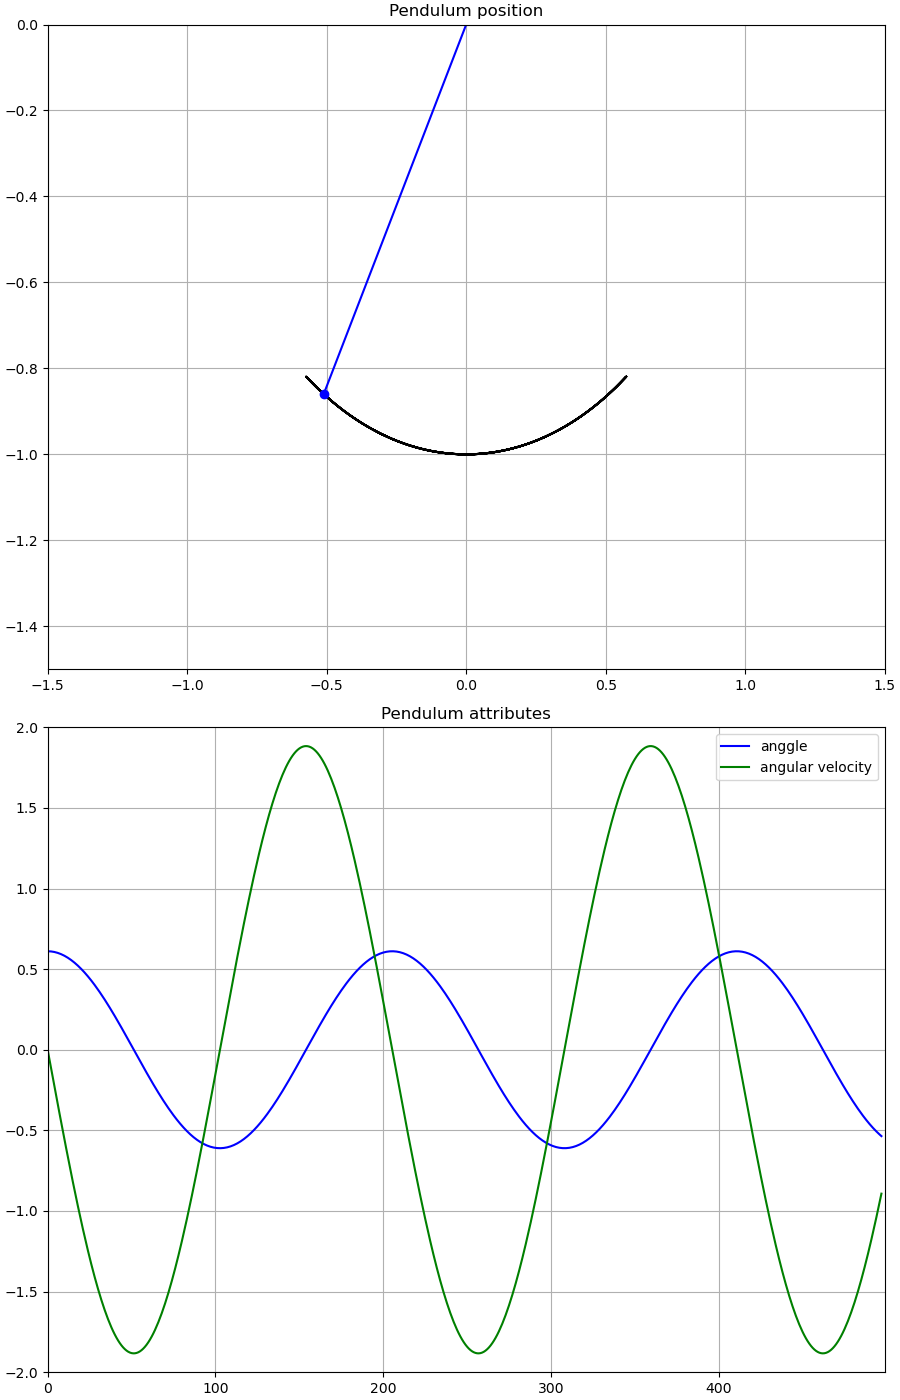

In [4]:
%matplotlib notebook
# Plot Animation
fig_of_plot, axes = plt.subplots(2,1, constrained_layout=True, figsize=(9,14))
axes[0].set_xlim((-1.5, 1.5))
axes[0].set_ylim((-1.5, 0))
axes[0].grid(visible=True)
axes[0].set_title('Pendulum position')
axes[1].grid(visible=True)
axes[1].set_title('Pendulum attributes')
axes[1].set_xlim((0, len(simulation_state_history)-1))
axes[1].set_ylim((-2, 2))


historical_movement, = axes[0].plot([],[],'-k')
rope, = axes[0].plot([], [], 'b-')
end_of_pendulum, = axes[0].plot([], [], 'bo')
angle, = axes[1].plot([], [], 'b-', label = "anggle")
angular_velocity, = axes[1].plot([], [], 'g-', label = "angular velocity")
axes[1].legend()

def update_plot(i):
    if i>1:
        lin_theta_history = np.array(simulation_state_history)[:i]
        first_values_history = lin_theta_history[:,0]
        lin_theta = first_values_history[-1]
        second_values_history = lin_theta_history[:,1]
        end_of_pendulum.set_data([np.sin(lin_theta),-np.cos(lin_theta)])
        historical_movement.set_data([np.sin(first_values_history),-np.cos(first_values_history)])
        rope.set_data([0,np.sin(lin_theta)],[0,-np.cos(lin_theta)])
        angle.set_data(np.arange(0, i, 1), first_values_history)
        angular_velocity.set_data(np.arange(0, i, 1), second_values_history)

ani = animation.FuncAnimation(fig_of_plot, update_plot, repeat=False,
                                    frames=len(simulation_state_history)-1, interval=1)


plt.show()

We define standard class for kalman filter as before. There are no changes

In [43]:
class ExtendedKalmanFilter(object):
     
    # x0 - initial guess of the state vector - this is the initial a posteriori estimate
    # P0 - initial guess of the covariance matrix of the state estimation error
    # Q  - covariance matrix of the process noise 
    # R  - covariance matrix of the measurement noise
    # dT - discretization period for the forward Euler method
     
    def __init__(self,x0,P0,Q,R,dT):
         
        # initialize vectors and matrices
        self.x0=x0
        self.P0=P0
        self.Q=Q
        self.R=R
        self.dT=dT
         
        # model parameters
        # gravitational constant
        self.g=9.81
        # length of the pendulum 
        self.l=1
         
        # this variable is used to track the current time step k of the estimator 
        # after every measurement arrives, this variables is incremented for +1 
        self.currentTimeStep=0
         
        # this list is used to store the a posteriori estimates hat{x}_k^{+} starting from the initial estimate 
        # note: the list starts from hat{x}_0^{+}=x0 - where x0 is an initial guess of the estimate provided by the user
        self.estimates_aposteriori=[]
        self.estimates_aposteriori.append(x0)
         
        # this list is used to store the a apriori estimates hat{x}_k^{-} starting from hat{x}_1^{-}
        # note: hat{x}_0^{-} does not exist, that is, the list starts from the time index 1
        self.estimates_apriori=[]
         
        # this list is used to store the a posteriori estimation error covariance matrices P_k^{+}
        # note: the list starts from P_0^{+}=P0, where P0 is the initial guess of the covariance provided by the user
        self.estimationErrorCovarianceMatricesAposteriori=[]
        self.estimationErrorCovarianceMatricesAposteriori.append(P0)
         
        # this list is used to store the a priori estimation error covariance matrices P_k^{-}
        # note: the list starts from P_1^{-}, that is, it starts from the time index 1
        self.estimationErrorCovarianceMatricesApriori=[]
         
        # this list is used to store the Kalman gain matrices K_k
        self.gainMatrices=[]
          
        # this list is used to store prediction errors error_k=y_k-self.outputEquation(x_k^{-})
        self.errors=[]
     
     
    # here is the continuous state-space model
    # inputs:
    #       x - state vector 
    #       t - time
    # NOTE THAT WE ARE NOT USING time since the dynamics is time invariant
    # output: 
    #       dxdt - the value of the state function (derivative of x)
    def stateSpaceContinuous(self,x,t):
        dxdt=np.array([[x[1,0]],[-(self.g/self.l)*np.sin(x[0,0])]])
        return dxdt
     
    # this function defines the discretized state-space model 
    # we use the forward Euler discretization 
    # input: 
    #       x_k   - current state x_{k}
    # output:
    #       x_kp1 - state propagated in time x_{k+1}
    def discreteTimeDynamics(self,x_k):
        # note over here that we are not using "self.currentTimeStep*self.DT" since the dynamics is time invariant
        # however, you might need to use this argument if your dynamics is time varying
        x_kp1=x_k+self.dT*self.stateSpaceContinuous(x_k,self.currentTimeStep*self.dT)
        return x_kp1
     
    # this function returns the Jacobian of the discrete-time state equation 
    # evaluated at x_k
    # That is, it returns the matrix A
    # input: 
    #       x_k - state 
    # output: 
    #       A - the Jacobian matrix of the state equation with respect to state
    def jacobianStateEquation(self,x_k):
        A=np.zeros(shape=(2,2))
        A[0,0]=1
        A[0,1]=self.dT
        A[1,0]=-self.dT*(self.g/self.l)*np.cos(x_k[0,0])
        A[1,1]=1
        return A
     
    # this function returns the Jacobian of the output equation 
    # evaluated at x_k
    # That is, it returns the matrix C
    # Note that since in the case of the pendulum the output is a linear function 
    # and consequently, we actually do not use x_k
    # however, in the case of nonlinear output functions we need x_k
    # input: 
    #      x_k - state 
    # output: 
    #      C   - the Jacobian matrix of the output equation with respect to state
    def jacobianOutputEquation(self,x_k):
        C=np.zeros(shape=(1,2))
        C[0,0]=1
        return C
     
    # this is the output equation
    # input: 
    #       x_k - state
    # output: 
    #       x_k[0]- output value at the current state
    def outputEquation(self,x_k):
        return x_k[0]
     
    # this function propagates x_{k-1}^{+} through the model to compute x_{k}^{-}
    # this function also propagates P_{k-1}^{+} through the time-covariance model to compute P_{k}^{-}
    # at the end, this function increments the time index self.currentTimeStep for +1
      
    def propagateDynamics(self):
        # propagate the a posteriori estimate to compute the a priori estimate
        xk_minus=self.discreteTimeDynamics(self.estimates_aposteriori[self.currentTimeStep])
        # linearize the dynamics at the a posteriori estimate 
        Akm1=self.jacobianStateEquation(self.estimates_aposteriori[self.currentTimeStep])
        # propagate the a posteriori covariance matrix in time to compute the a priori covariance
        Pk_minus=np.matmul(np.matmul(Akm1,self.estimationErrorCovarianceMatricesAposteriori[self.currentTimeStep]),Akm1.T)+self.Q
         
        # memorize the computed values and increment the time step
        self.estimates_apriori.append(xk_minus)
        self.estimationErrorCovarianceMatricesApriori.append(Pk_minus)
        self.currentTimeStep=self.currentTimeStep+1
     
    # this function computes the a posteriori estimate by using the measurements
    # this function should be called after propagateDynamics() because the time step should be increased and states and covariances should be propagated         
    # input:
    #       currentMeasurement - measurement at the time step k
    def computeAposterioriEstimate(self,currentMeasurement):
                 
         
        # linearize the output equation at the a priori estimate for the time step k
        Ck=self.jacobianOutputEquation(self.estimates_apriori[self.currentTimeStep-1]) 
        print(Ck)
        # compute the Kalman gain matrix
        # keep in mind that the a priori indices start from k=1, that is why we index a priori quantities with "self.currentTimeStep-1"
        Smatrix= self.R+np.matmul(np.matmul(Ck,self.estimationErrorCovarianceMatricesApriori[self.currentTimeStep-1]),Ck.T)
        print(Smatrix)
        # Kalman gain matrix
        Kk=np.matmul(self.estimationErrorCovarianceMatricesApriori[self.currentTimeStep-1],np.matmul(Ck.T,np.linalg.inv(Smatrix)))
         
        # update the estimate
        # prediction error
        error_k=currentMeasurement-self.outputEquation(self.estimates_apriori[self.currentTimeStep-1])
        # a posteriori estimate
        print(Kk)
        print(error_k)
        xk_plus=self.estimates_apriori[self.currentTimeStep-1]+np.matmul(Kk,np.array([error_k]))
        print(f"xk_plus {xk_plus}")
        
        # update the covariance matrix
        # a posteriori covariance matrix update 
        IminusKkC=np.eye(self.x0.shape[0])-np.matmul(Kk,Ck)
        print(f"R {self.R.shape}")
        print(f"K {Kk.shape}")
        print(f"second part {np.matmul(Kk,np.matmul(R,Kk.T))}")
        Pk_plus=np.matmul(IminusKkC,np.matmul(self.estimationErrorCovarianceMatricesApriori[self.currentTimeStep-1],IminusKkC.T))+np.matmul(Kk,np.matmul(self.R,Kk.T))
         
        # update the lists that store the vectors and matrices
        # Kalman gain matrix
        self.gainMatrices.append(Kk)
        # errors
        self.errors.append(error_k)
        # a posteriori estimates
        self.estimates_aposteriori.append(xk_plus)
        # a posteriori covariance matrix
        self.estimationErrorCovarianceMatricesAposteriori.append(Pk_plus)

<IPython.core.display.Javascript object>


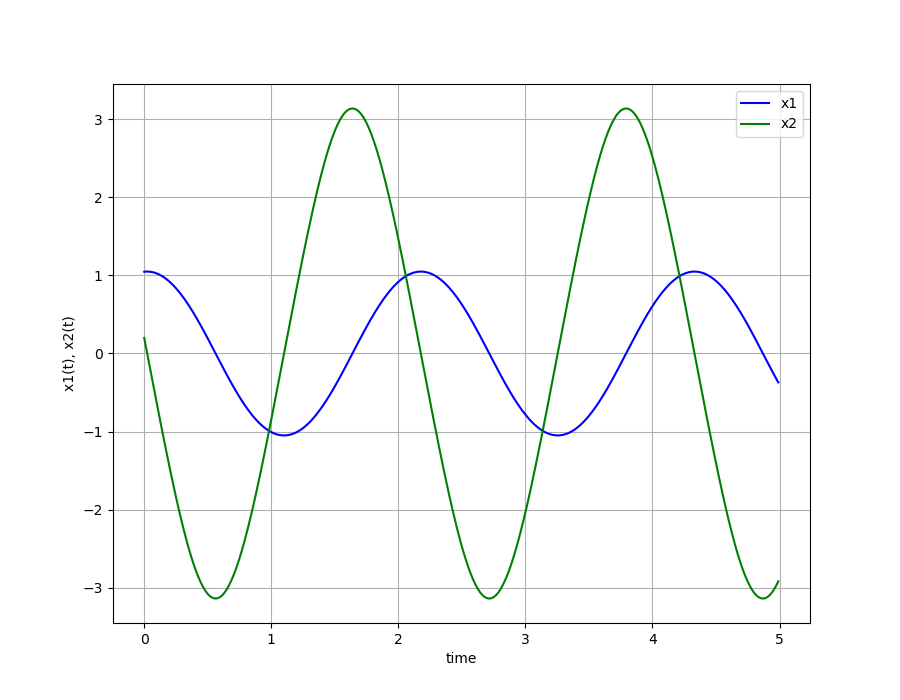

In [44]:
%matplotlib notebook
# discretization time step
# it is used for both integration of the pendulum differential equation and for
# forward Euler method discretization
deltaTime=0.01
# initial condition for generating the simulation data 
x0=np.array([np.pi/3,0.2])
 
# time steps for simulation
simulationSteps=500
# total simulation time 
totalSimulationTimeVector=np.arange(0,simulationSteps*deltaTime,deltaTime)
 
# this state-space model defines the continuous dynamics of the pendulum
# this function is passed as an argument of the odeint() function for integrating (solving) the dynamics 
def stateSpaceModel(x,t):
    g=9.81
    # 
    l=1
    dxdt=np.array([x[1],-(g/l)*np.sin(x[0])])
    return dxdt
 
# here we integrate the dynamics
# the output: "solutionOde" contains time series of the angle and angular velocity 
# these time series represent the time series of the true state that we want to estimate
solutionOde=odeint(stateSpaceModel,x0,totalSimulationTimeVector)
  
# uncomment this if you want to plot the simulation results 
plt.figure(figsize = (9,7))
plt.plot(totalSimulationTimeVector, solutionOde[:, 0], 'b', label='x1')
plt.plot(totalSimulationTimeVector, solutionOde[:, 1], 'g', label='x2')
plt.legend(loc='best')
plt.xlabel('time')
plt.ylabel('x1(t), x2(t)')
plt.grid()
#plt.savefig('simulation.png',dpi=600)
plt.show()

[[1. 0.]]
[[102.01]]
[[ 0.99019704]
 [-0.0747926 ]]
[-5.75131705]
xk_plus [[1.10357748]
 [2.35423587]]
R (1, 1)
K (2, 1)
second part [[ 0.98049018 -0.07405941]
 [-0.07405941  0.00559393]]
[[1. 0.]]
[[2.99881859]]
[[0.66653535]
 [0.29786046]]
[-0.07834722]
xk_plus [[1.07489865]
 [2.24331326]]
R (1, 1)
K (2, 1)
second part [[0.44426937 0.19853452]
 [0.19853452 0.08872085]]
[[1. 0.]]
[[2.68268421]]
[[0.62723902]
 [0.47928649]]
[-0.0478344]
xk_plus [[1.06732818]
 [2.13410382]]
R (1, 1)
K (2, 1)
second part [[0.39342879 0.30062719]
 [0.30062719 0.22971554]]
[[1. 0.]]
[[2.64705214]]
[[0.62222127]
 [0.55613254]]
[-0.03929774]
xk_plus [[1.06421733]
 [2.02632185]]
R (1, 1)
K (2, 1)
second part [[0.38715931 0.3460375 ]
 [0.3460375  0.3092834 ]]
[[1. 0.]]
[[2.64358505]]
[[0.62172581]
 [0.58646299]]
[-0.03608557]
xk_plus [[1.06204522]
 [1.91937943]]
R (1, 1)
K (2, 1)
second part [[0.38654298 0.36461918]
 [0.36461918 0.34393884]]
[[1. 0.]]
[[2.64370012]]
[[0.62174227]
 [0.59801787]]
[-0.03467066]
x

 [0.37196916 0.35789691]]
[[1. 0.]]
[[2.64387367]]
[[0.6217671 ]
 [0.59813603]]
[-0.00483902]
xk_plus [[ 1.03949087]
 [-0.19544808]]
R (1, 1)
K (2, 1)
second part [[0.38659433 0.37190131]
 [0.37190131 0.35776671]]
[[1. 0.]]
[[2.64387083]]
[[0.6217667]
 [0.5980004]]
[-0.0047878]
xk_plus [[ 1.0345595 ]
 [-0.28288775]]
R (1, 1)
K (2, 1)
second part [[0.38659382 0.37181673]
 [0.37181673 0.35760448]]
[[1. 0.]]
[[2.64386738]]
[[0.6217662 ]
 [0.59783824]]
[-0.00473639]
xk_plus [[ 1.02878569]
 [-0.37004977]]
R (1, 1)
K (2, 1)
second part [[0.38659321 0.37171561]
 [0.37171561 0.35741056]]
[[1. 0.]]
[[2.6438633]]
[[0.62176562]
 [0.59764987]]
[-0.00468478]
xk_plus [[ 1.02217236]
 [-0.45688927]]
R (1, 1)
K (2, 1)
second part [[0.38659249 0.37159814]
 [0.37159814 0.35718536]]
[[1. 0.]]
[[2.64385863]]
[[0.62176495]
 [0.59743567]]
[-0.00463295]
xk_plus [[ 1.01472286]
 [-0.54336029]]
R (1, 1)
K (2, 1)
second part [[0.38659165 0.37146456]
 [0.37146456 0.35692939]]
[[1. 0.]]
[[2.64385336]]
[[0.6217642 ]

second part [[0.38658706 0.37078156]
 [0.37078156 0.35562225]]
[[1. 0.]]
[[2.64382557]]
[[0.62176022]
 [0.59601549]]
[-0.00142039]
xk_plus [[ 0.96819436]
 [-1.12013769]]
R (1, 1)
K (2, 1)
second part [[0.38658577 0.37057872]
 [0.37057872 0.35523447]]
[[1. 0.]]
[[2.64381777]]
[[0.6217591 ]
 [0.59566777]]
[-0.00139662]
xk_plus [[ 0.95612462]
 [-1.20179064]]
R (1, 1)
K (2, 1)
second part [[0.38658438 0.37036186]
 [0.37036186 0.35482009]]
[[1. 0.]]
[[2.64380946]]
[[0.62175792]
 [0.59529836]]
[-0.00137219]
xk_plus [[ 0.94325355]
 [-1.28275155]]
R (1, 1)
K (2, 1)
second part [[0.38658291 0.37013147]
 [0.37013147 0.35438013]]
[[1. 0.]]
[[2.64380065]]
[[0.62175666]
 [0.59490814]]
[-0.00134709]
xk_plus [[ 0.92958847]
 [-1.36296222]]
R (1, 1)
K (2, 1)
second part [[0.38658134 0.3698881 ]
 [0.3698881  0.3539157 ]]
[[1. 0.]]
[[2.64379136]]
[[0.62175533]
 [0.59449808]]
[-0.00132129]
xk_plus [[ 0.91513733]
 [-1.4423625 ]]
R (1, 1)
K (2, 1)
second part [[0.38657969 0.36963235]
 [0.36963235 0.35342796

<IPython.core.display.Javascript object>


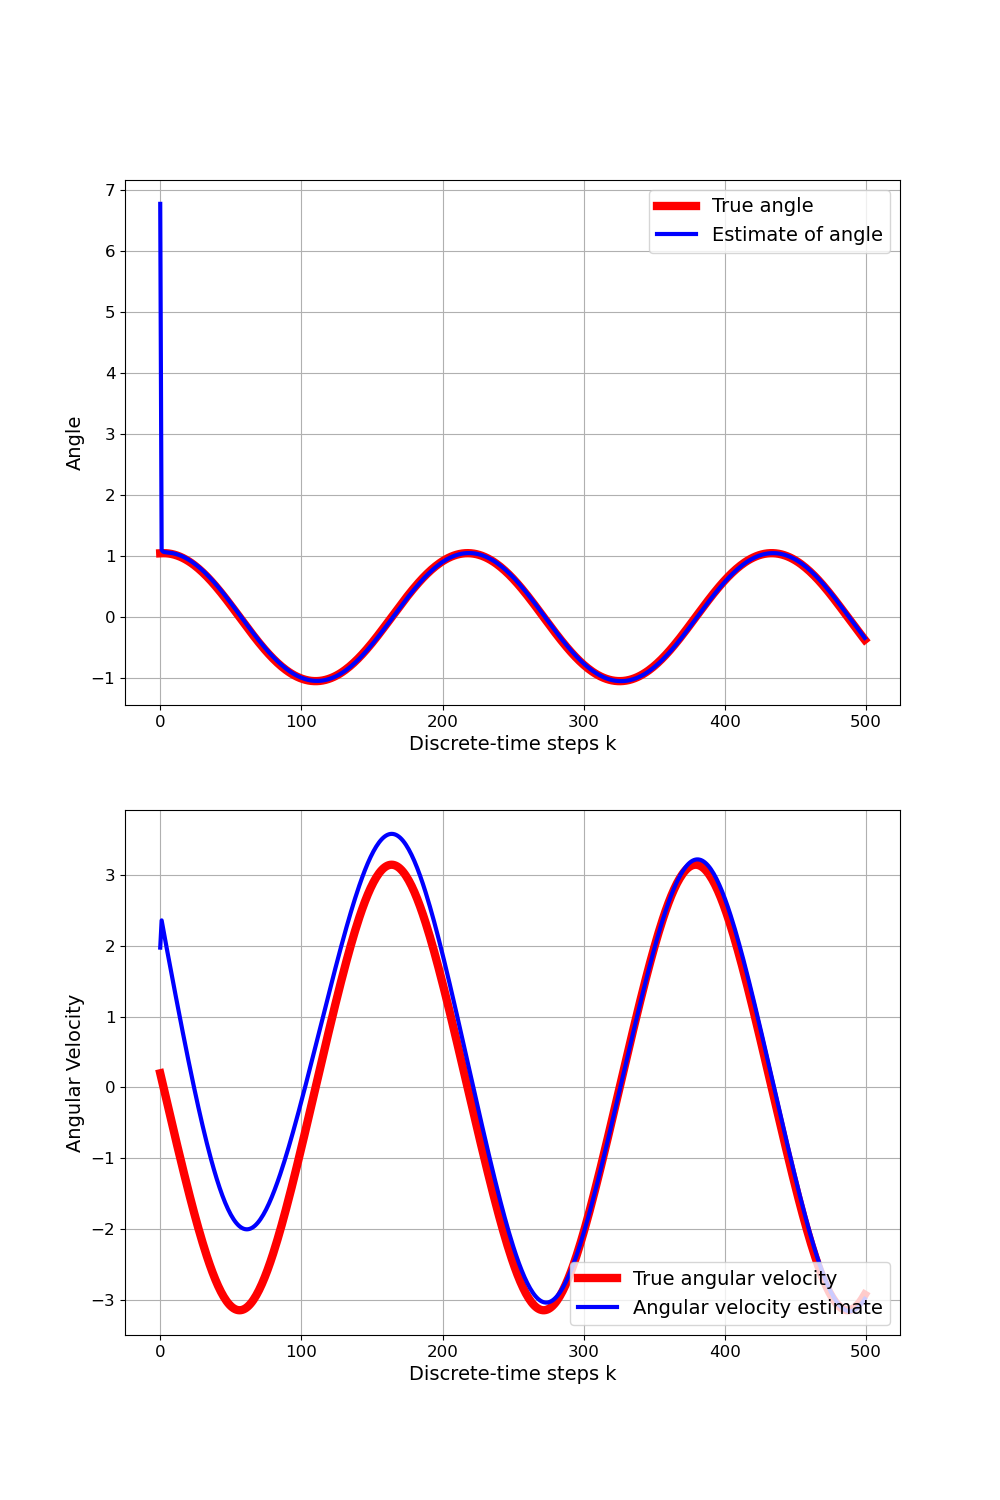

In [45]:
#create the Kalman filter object 
# this is an initial guess of the state estimate
x0guess=np.zeros(shape=(2,1))
x0guess[0]=x0[0]+4*np.random.randn()
x0guess[1]=x0[1]+4*np.random.randn()
 
# initial value of the covariance matrix
P0=100*np.eye(2,2)
# discretization stpe
dT=deltaTime
# process noise covariance matrix
# note that we do not have the process noise
Q=1*np.eye(2,2)
# measurement noise covariance matrix
# note that we do not have measurement noise in this simulation 
# see driverCodeNoise.py for the performance when the measurement noise
# is affecting the outputs
R=np.array([[1]])
 
# create the extended Kalman filter object
KalmanFilterObject=ExtendedKalmanFilter(x0guess,P0,Q,R,dT)
 
 
# simulate the extended Kalman filter 
for j in range(simulationSteps-1):
    # TWO STEPS
    # (1) propagate a posteriori estimate and covariance matrix
    KalmanFilterObject.propagateDynamics()
     
    # (2) take into account the current measurement and 
    # compute the a posteriori estimate and covarance matrix
    # note that we use the exact solution of the differential 
    # equations as measurements
    # note also that we only measure the angle of the pendulum
    KalmanFilterObject.computeAposterioriEstimate(solutionOde[j, 0])
 
# Estimates
#KalmanFilterObject.estimates_aposteriori
# Covariance matrices
#KalmanFilterObject.estimationErrorCovarianceMatricesAposteriori
# Kalman gain matrices
#KalmanFilterObject.gainMatrices.append(Kk)
# errors
#KalmanFilterObject.errors.append(error_k)
 
# extract the state estimates in order to plot the results
estimateAngle=[]
estimateAngularVelocity=[]
for j in np.arange(np.size(totalSimulationTimeVector)):
    estimateAngle.append(KalmanFilterObject.estimates_aposteriori[j][0,0])
    estimateAngularVelocity.append(KalmanFilterObject.estimates_aposteriori[j][1,0])
    
     
# create vectors corresponding to the true values in order to plot the results
trueAngle=solutionOde[:,0]
trueAngularVelocity=solutionOde[:,1]
 
 
# plot the results
steps=np.arange(np.size(totalSimulationTimeVector))
fig, ax = plt.subplots(2,1,figsize=(10,15))
ax[0].plot(steps,trueAngle,color='red',linestyle='-',linewidth=6,label='True angle')
ax[0].plot(steps,estimateAngle,color='blue',linestyle='-',linewidth=3,label='Estimate of angle')
ax[0].set_xlabel("Discrete-time steps k",fontsize=14)
ax[0].set_ylabel("Angle",fontsize=14)
ax[0].tick_params(axis='both',labelsize=12)
ax[0].grid()
ax[0].legend(fontsize=14)
 
ax[1].plot(steps,trueAngularVelocity,color='red',linestyle='-',linewidth=6,label='True angular velocity')
ax[1].plot(steps,estimateAngularVelocity,color='blue',linestyle='-',linewidth=3,label='Angular velocity estimate')
ax[1].set_xlabel("Discrete-time steps k",fontsize=14)
ax[1].set_ylabel("Angular Velocity",fontsize=14)
ax[1].tick_params(axis='both',labelsize=12)
ax[1].grid()
ax[1].legend(fontsize=14,loc="lower right")
#fig.savefig('estimationResults.png',dpi=600)

[[1. 0.]]
[[102.01]]
[[0.99019704]
 [0.09148413]]
[4.27596095]
R [[1]]
K [[0.99019704]
 [0.09148413]]
second part [[0.98049018 0.09058731]
 [0.09058731 0.00836935]]
[[1. 0.]]
[[3.00211077]]
[[0.66690103]
 [0.33908733]]
[0.00573434]
R [[1]]
K [[0.66690103]
 [0.33908733]]
second part [[0.44475699 0.22613769]
 [0.22613769 0.11498022]]
[[1. 0.]]
[[2.68383148]]
[[0.62739836]
 [0.4843861 ]]
[-0.03432598]
R [[1]]
K [[0.62739836]
 [0.4843861 ]]
second part [[0.39362871 0.30390305]
 [0.30390305 0.2346299 ]]
[[1. 0.]]
[[2.64726679]]
[[0.6222519 ]
 [0.54851606]]
[-0.04886055]
R [[1]]
K [[0.6222519 ]
 [0.54851606]]
second part [[0.38719743 0.34131516]
 [0.34131516 0.30086987]]
[[1. 0.]]
[[2.64341595]]
[[0.62170161]
 [0.57426216]]
[-0.0542482]
R [[1]]
K [[0.62170161]
 [0.57426216]]
second part [[0.38651289 0.35701971]
 [0.35701971 0.32977703]]
[[1. 0.]]
[[2.64338509]]
[[0.62169719]
 [0.58418919]]
[-0.05598532]
R [[1]]
K [[0.62169719]
 [0.58418919]]
second part [[0.3865074  0.36318878]
 [0.36318878 

 [0.58651446]]
[-0.00742045]
R [[1]]
K [[0.6217303 ]
 [0.58651446]]
second part [[0.38654856 0.36465381]
 [0.36465381 0.34399921]]
[[1. 0.]]
[[2.64361354]]
[[0.62172988]
 [0.58638653]]
[-0.00733847]
R [[1]]
K [[0.62172988]
 [0.58638653]]
second part [[0.38654805 0.36457403]
 [0.36457403 0.34384916]]
[[1. 0.]]
[[2.64361044]]
[[0.62172944]
 [0.58624926]]
[-0.00725656]
R [[1]]
K [[0.62172944]
 [0.58624926]]
second part [[0.3865475  0.36448842]
 [0.36448842 0.34368819]]
[[1. 0.]]
[[2.64360713]]
[[0.62172897]
 [0.5861031 ]]
[-0.00717473]
R [[1]]
K [[0.62172897]
 [0.5861031 ]]
second part [[0.38654691 0.36439728]
 [0.36439728 0.34351685]]
[[1. 0.]]
[[2.64360361]]
[[0.62172846]
 [0.58594854]]
[-0.00709296]
R [[1]]
K [[0.62172846]
 [0.58594854]]
second part [[0.38654628 0.36430089]
 [0.36430089 0.34333569]]
[[1. 0.]]
[[2.64359991]]
[[0.62172793]
 [0.5857861 ]]
[-0.00701127]
R [[1]]
K [[0.62172793]
 [0.5857861 ]]
second part [[0.38654562 0.36419958]
 [0.36419958 0.34314535]]
[[1. 0.]]
[[2.64359

[[1. 0.]]
[[2.64357853]]
[[0.62172487]
 [0.58488357]]
[-0.00131545]
R [[1]]
K [[0.62172487]
 [0.58488357]]
second part [[0.38654182 0.36363666]
 [0.36363666 0.34208879]]
[[1. 0.]]
[[2.64357407]]
[[0.62172424]
 [0.58468968]]
[-0.00128733]
R [[1]]
K [[0.62172424]
 [0.58468968]]
second part [[0.38654103 0.36351574]
 [0.36351574 0.34186202]]
[[1. 0.]]
[[2.64356951]]
[[0.62172358]
 [0.58449204]]
[-0.00125875]
R [[1]]
K [[0.62172358]
 [0.58449204]]
second part [[0.38654021 0.36339249]
 [0.36339249 0.34163095]]
[[1. 0.]]
[[2.64356487]]
[[0.62172292]
 [0.58429137]]
[-0.00122972]
R [[1]]
K [[0.62172292]
 [0.58429137]]
second part [[0.38653939 0.36326733]
 [0.36326733 0.3413964 ]]
[[1. 0.]]
[[2.64356017]]
[[0.62172225]
 [0.58408838]]
[-0.00120025]
R [[1]]
K [[0.62172225]
 [0.58408838]]
second part [[0.38653855 0.36314074]
 [0.36314074 0.34115924]]
[[1. 0.]]
[[2.64355543]]
[[0.62172157]
 [0.58388383]]
[-0.00117035]
R [[1]]
K [[0.62172157]
 [0.58388383]]
second part [[0.38653771 0.36301317]
 [0.36

<IPython.core.display.Javascript object>


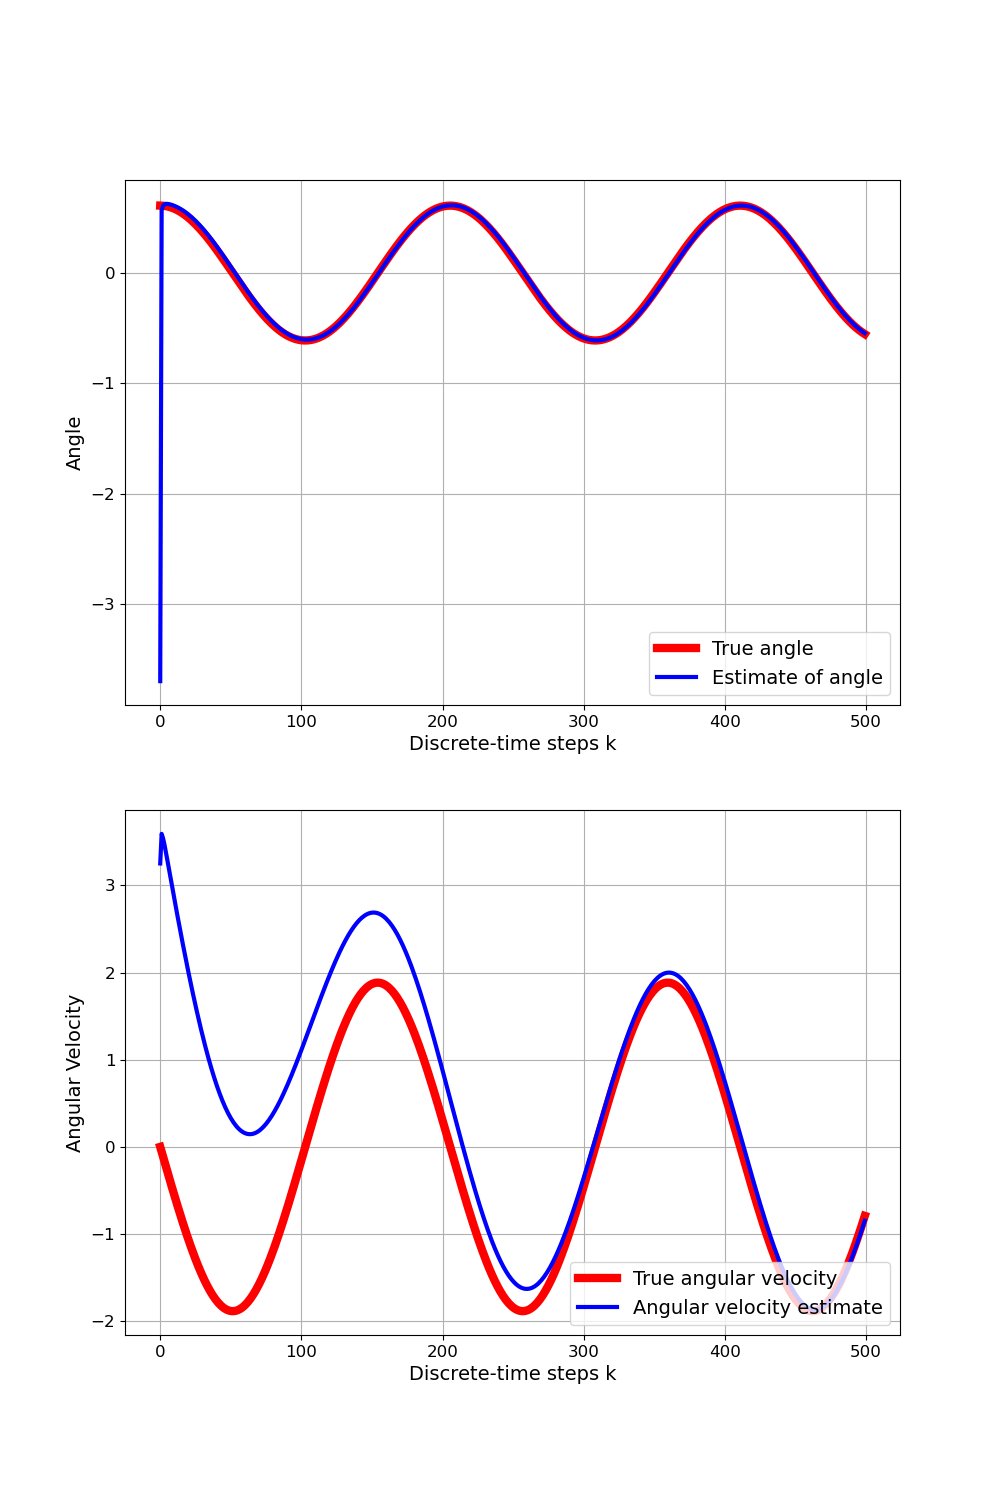

In [36]:
#create the Kalman filter object 
 
# initial value of the covariance matrix
P0=100*np.eye(2,2)
# discretization stpe
dT=deltaTime
# process noise covariance matrix
# note that we do not have the process noise
Q=1*np.eye(2,2)
# measurement noise covariance matrix
# note that we do not have measurement noise in this simulation 
# see driverCodeNoise.py for the performance when the measurement noise
# is affecting the outputs
R=np.array([[1]])
 
# create the extended Kalman filter object
KalmanFilterObject=ExtendedKalmanFilter(x0guess,P0,Q,R,dT)
 
 
# simulate the extended Kalman filter 
for j in range(len(simulation_state_history)-1):
    # TWO STEPS
    # (1) propagate a posteriori estimate and covariance matrix
    KalmanFilterObject.propagateDynamics()
     
    # (2) take into account the current measurement and 
    # compute the a posteriori estimate and covarance matrix
    # note that we use the exact solution of the differential 
    # equations as measurements
    # note also that we only measure the angle of the pendulum
    KalmanFilterObject.computeAposterioriEstimate(simulation_state_history[j, 0])
 
# Estimates
#KalmanFilterObject.estimates_aposteriori
# Covariance matrices
#KalmanFilterObject.estimationErrorCovarianceMatricesAposteriori
# Kalman gain matrices
#KalmanFilterObject.gainMatrices.append(Kk)
# errors
#KalmanFilterObject.errors.append(error_k)
 
# extract the state estimates in order to plot the results
estimateAngle=[]
estimateAngularVelocity=[]
for j in np.arange(np.size(totalSimulationTimeVector)):
    estimateAngle.append(KalmanFilterObject.estimates_aposteriori[j][0,0])
    estimateAngularVelocity.append(KalmanFilterObject.estimates_aposteriori[j][1,0])
    
     
# create vectors corresponding to the true values in order to plot the results
trueAngle=simulation_state_history[:,0]
trueAngularVelocity=simulation_state_history[:,1]
 
 
# plot the results
steps=np.arange(np.size(totalSimulationTimeVector))
fig, ax = plt.subplots(2,1,figsize=(10,15))
ax[0].plot(steps,trueAngle,color='red',linestyle='-',linewidth=6,label='True angle')
ax[0].plot(steps,estimateAngle,color='blue',linestyle='-',linewidth=3,label='Estimate of angle')
ax[0].set_xlabel("Discrete-time steps k",fontsize=14)
ax[0].set_ylabel("Angle",fontsize=14)
ax[0].tick_params(axis='both',labelsize=12)
ax[0].grid()
ax[0].legend(fontsize=14)
 
ax[1].plot(steps,trueAngularVelocity,color='red',linestyle='-',linewidth=6,label='True angular velocity')
ax[1].plot(steps,estimateAngularVelocity,color='blue',linestyle='-',linewidth=3,label='Angular velocity estimate')
ax[1].set_xlabel("Discrete-time steps k",fontsize=14)
ax[1].set_ylabel("Angular Velocity",fontsize=14)
ax[1].tick_params(axis='both',labelsize=12)
ax[1].grid()
ax[1].legend(loc= "lower right", fontsize=14)
#fig.savefig('estimationResults.png',dpi=600)

In [17]:
x0guess

array([[-0.77926884],
       [-7.30010144]])